# Earthquake Statistics

In this notebook we will explore some basics of earthquake statistics including Gutenberg-Richter distributions and Omori aftershock decays.

## Magnitude-frequency relations

As you will see in Stein and Wysession, chapter 4.7, the number of earthquakes of a given magnitude generally follows a characteristic distribution, known as the *Gutenberg-Richter* distribution, of the form:

\begin{equation*}
   \log{N} = a - bM,
\end{equation*}

where  $N$ is the number of earthquake with magnitude greater than $M$ occurring in a given time. The two constants, $a$ and $b$, are the intercept and gradient of a linear fit to these data. Lets have a look at some data from New Zealand to start with. Note that we need to ensure that we are only using a single set of self-consistent magnitudes: GeoNet provides multiple different magnitudes for events, including a summary magnitude. We will just compare local magnitudes.

In [1]:
%matplotlib notebook

<IPython.core.display.Javascript object>


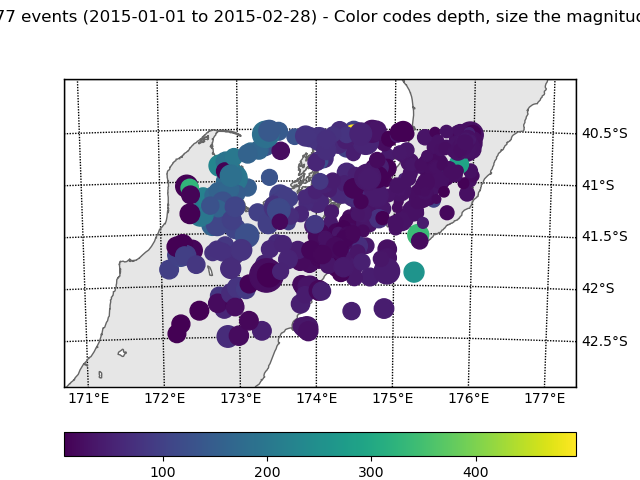

/home/chambeca/miniconda3/envs/gphs445/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


In [5]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

# Selecting data from around "central" New Zealand
region = [-42.5, -40.5, 172, 176]
starttime, endtime = UTCDateTime(2015, 1, 1), UTCDateTime(2015, 3, 1)
client = Client("GEONET")

catalog = client.get_events(
    starttime=starttime, endtime=endtime,
    minlatitude=region[0], maxlatitude=region[1],
    minlongitude=region[2], maxlongitude=region[3])

fig = catalog.plot(projection="local", resolution="h")

Nice, that is a useful number of earthquakes. Lets extract consistent magnitudes for each event, and put them into a numpy array for later use:

In [6]:
import numpy as np

magnitudes = np.array([m.mag for ev in catalog for m in ev.magnitudes if m.magnitude_type == "MLv"])
print(f"Found {len(magnitudes)} magnitudes from {len(catalog)} events")

Found 677 magnitudes from 677 events


<IPython.core.display.Javascript object>


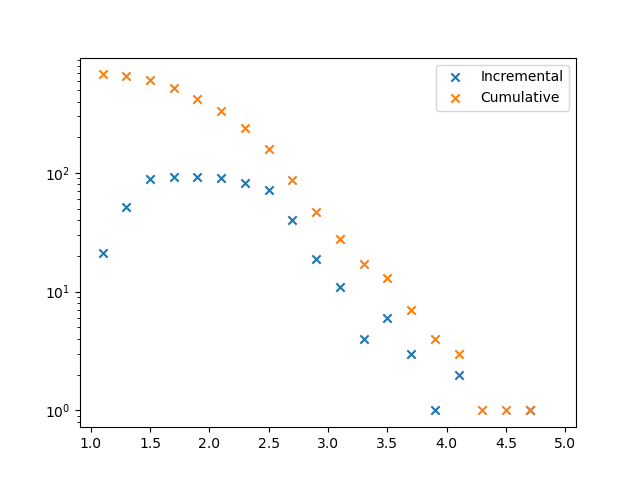

In [7]:
import matplotlib.pyplot as plt

bin_size = 0.2

magnitudes.sort()
min_mag, max_mag = magnitudes[0] // 1, (magnitudes[-1] // 1) + 1
bins = np.arange(min_mag, max_mag + bin_size, bin_size)
# Work out the number of events in each bin
hist, bin_edges = np.histogram(magnitudes, bins=bins)
# Compute the total events below M
cumulative_hist = np.flip(np.flip(hist).cumsum())
bin_mid_points = bin_edges - (bin_size / 2)

fig, ax = plt.subplots()
ax.scatter(bin_mid_points[1:], hist, marker="x", label="Incremental")
ax.scatter(bin_mid_points[1:], cumulative_hist, marker="x", label="Cumulative")
ax.set_yscale("log")

ax.legend()

Hopefully you can see that, for the cumulative version at least, the scatter of magnitudes is nearly linear across most of the magnitude range in this logarithmic Y-scale plot. This is the fundamental observation that Gutenberg and Richter were describing with their simple relation. The fit to this relation in global data is generally found to have a *b-value* (inverse of gradient) of 1, **above some magnitude of completeness**.

The concept of magnitude of completeness (often referred to as $M_c$) is important, and defines the magnitude above which we think that the catalogue contains all the earthquakes that actually occurred in that region and time-span. This limit is defined by a few factors, but it most strongly relates to the detection capabilities of the network, which is a function of station quality, density, detection algorithm, earthquake rate, ... the list is long!. Suffice to say, all catalogues are incomplete, but it is important to know *how* incomplete they are so that we can understand the limitations of those catalogues.

We will think about how we estimate magnitude of completeness in a moment, but to start with lets assume the magnitude of completeness is about 2.5 here and fit all the cumulative data above that value. We can then work out the b-value.

<IPython.core.display.Javascript object>


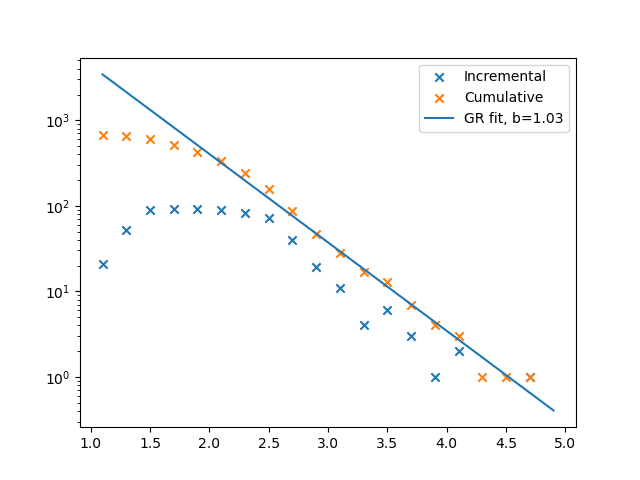

In [18]:
mc = 2.5
mask = np.logical_and(bin_mid_points[1:] >= mc, cumulative_hist > 0)

gr_fit = np.polynomial.Polynomial.fit(
    bin_mid_points[1:][mask], 
    np.log10(cumulative_hist[mask]), 
    deg=1
)
a, b = gr_fit.convert().coef
b *= -1  # Invert for b-value

fitted = 10 ** (a - (b * bin_mid_points[1:]))

fig, ax = plt.subplots()
ax.scatter(bin_mid_points[1:], hist, marker="x", label="Incremental")
ax.scatter(bin_mid_points[1:], cumulative_hist, marker="x", label="Cumulative")
ax.plot(bin_mid_points[1:], fitted, label=f"GR fit, b={b:.2f}")
ax.set_yscale("log")

ax.legend()


You can see that these NZ data have a similar fit to the global dataset presented in Stein and Wysession (Figure 4.7-1). Great! But that is just one time window and one part of the country.

**Exercise:** Pick a different region in NZ and time window (don't select more than a couple of months of data because it will take a while to download the catalogue from GeoNet!) and compute the b-value for that. Does it look like the completeness is the same?

In [19]:
# Your code here

### Magnitude of completeness

We have talked about what affects $M_c$, and we can try to fit this in a robust way. One way to do this is to use the "Goodness-of-fit" method discussed by Wiemer & Wyss 2000. We will use a function included in the course utilities to compute the fit quality for a range of b-values.

In [7]:
from gphs445_utilities.statistics import calc_b_value
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import numpy as np

# Selecting data from around "central" New Zealand
region = [-42.5, -40.5, 172, 176]
starttime, endtime = UTCDateTime(2015, 1, 1), UTCDateTime(2016, 1, 1)
client = Client("GEONET")

catalog = client.get_events(
    starttime=starttime, endtime=endtime,
    minlatitude=region[0], maxlatitude=region[1],
    minlongitude=region[2], maxlongitude=region[3])

magnitudes = np.array(
    [m.mag for ev in catalog for m in ev.magnitudes 
     if m.magnitude_type == "MLv"])

<IPython.core.display.Javascript object>


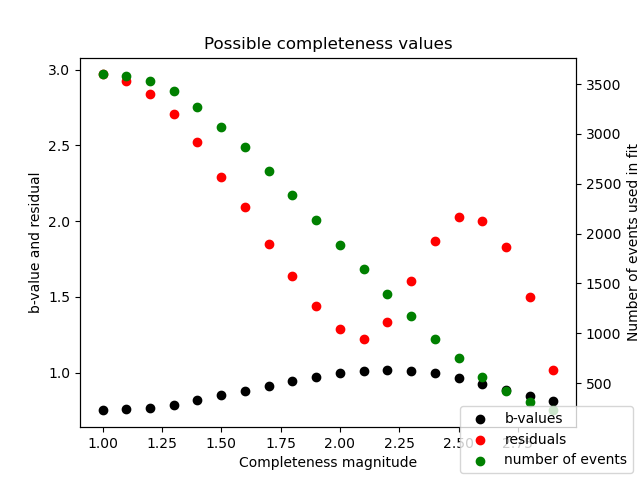

In [8]:
fitted = calc_b_value(magnitudes, completeness=np.arange(1, 3, 0.1), plotvar=True, max_mag=4)

In this plot, higher residuals are better fits to the data. The low residual around $M_c = 2.1$ suggests that our true completeness is above that value, and the most likely completeness is right around 2.5, as we had eye-balled for the smaller three-month catalogue earlier! This means that above $M_{Lv}$ we expect that GeoNet got almost all of the earthquakes in this time-period. Good job. But it also means that below that value we shouldn't expect to have all the earthquakes, so any analysis we do on those smaller earthquakes in inherently limited.

Magnitude of completeness isn't fixed in time though... All the elements that we thought about earlier are time variable (noise, number of stations, earthquake rate, ...) and so we should expect $M_c$ to vary with time. IMHO any paper that looks at catalogue statistics without considering time-varying $M_c$ should be looked at sceptically! [This paper by Hainzl](https://pubs.geoscienceworld.org/ssa/srl/article/87/2A/337/315654/Rate-Dependent-Incompleteness-of-Earthquake?casa_token=JQNmlUIdw24AAAAA:O0TnaBnHTl4k10FDRov5mVrcbM653MuX2bXbGzmAC6UUk8TrqcKnB0WWnEjyBHKLP9UkzsfyGg), earthquake-rate strongly affects catalogue completeness, and must be taken into account when considering the statistics of aftershock sequences (unless a fixed magnitude cut-off is used that is equal to or exceeds the maximum $M_c$).

**Exercise:** Try computing the magnitude of completeness of the GeoNet catalogue in the same region for the two weeks after the Kaikōura earthquake.

In [10]:
# Your code here.

## Aftershock decay

In [11]:
from gphs445_utilities.statistics import calc_b_value
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import numpy as np

# Selecting data from around "central" New Zealand
region = [-42.5, -40.5, 172, 176]
starttime, endtime = UTCDateTime(2016, 11, 13), UTCDateTime(2016, 12, 13)
client = Client("GEONET")

catalog = client.get_events(
    starttime=starttime, endtime=endtime,
    minlatitude=region[0], maxlatitude=region[1],
    minlongitude=region[2], maxlongitude=region[3])

AttributeError: id

In [15]:
# Set the MLv to be the preferred magnitude
mlv_events = []
for event in catalog:
    try:
        mlv = [m for m in event.magnitudes if m.magnitude_type == "MLv"][0]
    except IndexError:
        continue
    event.preferred_magnitude_id = mlv.resource_id
    mlv_events.append(event)
catalog.events = mlv_events
print(f"I have a catalogue of {len(catalog)} events")

I have a catalogue of 7858 events


In [18]:
from gphs445_utilities.sequence_statistics import Aftershocks

mainshock = client.get_events(eventid="2016p858000")[0]

aftershocks = Aftershocks(
    catalog=catalog,
    mainshock=mainshock
)

/mnt/Water_Boy/Dropbox/Teaching/GPHS445/GPHS445_notebooks/gphs445_utilities/sequence_statistics.py:78: RuntimeWarning: invalid value encountered in log
  sum_log = np.sum(np.log(event_times + c))


<IPython.core.display.Javascript object>


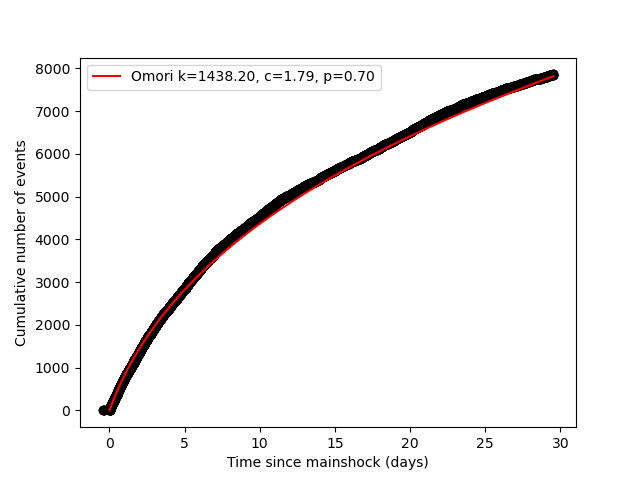

(1438.2029732343592,
 180.64275703427364,
 1.7859019751241885,
 0.35735478446326496,
 0.6974315169886013,
 0.040070599750719575)

In [19]:
aftershocks.omori(plot=True)